# Part 1: Setup & Imports

In [2]:
import numpy as np
import tensorflow as tf
import mne
from tqdm.notebook import tqdm
from collections import Counter

# --- Model Building (Keras) ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM,
    Conv1D, MaxPooling1D, Flatten,
    TimeDistributed, Permute, Bidirectional,
    Conv2D, DepthwiseConv2D, AveragePooling2D, BatchNormalization,
    Reshape, Activation
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers # Added for L2 regularization

# --- Baseline Models & Evaluation (Scikit-learn) ---
from sklearn.model_selection import KFold, cross_validate, StratifiedGroupKFold # <-- UPDATED
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

2025-12-08 14:38:42.047388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765204722.202365      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765204722.253238      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# REPLACE your "Load Data & Define Constants" cell with this:
print("Loading new epoch-level data...")
X_epochs_3d = np.load('../input/eeg-mp2k25/X_data_epochs.npy') # e.g. (1923, 20, 24)
y = np.load('../input/eeg-mp2k25/y_labels_epochs.npy')       # e.g. (1923,)
groups = np.load('../input/eeg-mp2k25/groups.npy')             # e.g. (1923,)

print(f"✅ X data shape: {X_epochs_3d.shape}")
print(f"✅ y labels shape: {y.shape}")
print(f"✅ groups shape: {groups.shape}")

# --- Define Project Constants ---
N_SPLITS = 10
RANDOM_STATE = 42

# NEW Input shape for DL model (channels, samples)
MODEL_INPUT_SHAPE = X_epochs_3d.shape[1:] # e.g. (20, 24)

Loading new epoch-level data...
✅ X data shape: (3801, 20, 1251)
✅ y labels shape: (3801,)
✅ groups shape: (3801,)


In [4]:
# --- Verify Class Imbalance ---
counts = Counter(y)
print(f"\nData balance check: {counts}")
if len(counts) == 2:
    print(f"Class 0 (Healthy?): {counts[0] / len(y):.2%}")
    print(f"Class 1 (MDD?):     {counts[1] / len(y):.2%}")
else:
    print("WARNING: Data contains only one class. Please check your preprocessing notebook.")


Data balance check: Counter({0: 1969, 1: 1832})
Class 0 (Healthy?): 51.80%
Class 1 (MDD?):     48.20%


# *Part 2: Feature Engineering (Baseline feature Extraction - PSD)*

In [5]:
# --- PSD - (Power Spectral Density) Feature Extraction ---
print("\nExtracting spectral (PSD) features for baseline models...")

SAMPLING_FREQ = 250
BANDS = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 12],
    'beta': [12, 30]
}
N_CHANNELS = X_epochs_3d.shape[1]
n_epochs = X_epochs_3d.shape[0]

n_features_per_epoch = N_CHANNELS * len(BANDS)
X_features_2D = np.zeros((n_epochs, n_features_per_epoch))

for epoch_idx in tqdm(range(n_epochs), desc="Extracting Features"):
    epoch_data = X_epochs_3d[epoch_idx, :, :]

    psd, freqs = mne.time_frequency.psd_array_welch(
        epoch_data, sfreq=SAMPLING_FREQ, fmin=0.5, fmax=30.0,
        n_fft=int(SAMPLING_FREQ * 2), verbose=False
    )

    epoch_band_features = []
    for fmin, fmax in BANDS.values():
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        mean_power_in_band = np.mean(psd[:, band_mask], axis=1)
        epoch_band_features.append(mean_power_in_band)

    X_features_2D[epoch_idx] = np.concatenate(epoch_band_features)

print(f"\nFeature extraction complete. Final 2D data shape: {X_features_2D.shape}")


Extracting spectral (PSD) features for baseline models...


Extracting Features:   0%|          | 0/3801 [00:00<?, ?it/s]


Feature extraction complete. Final 2D data shape: (3801, 80)


# Part 3: Model Definitions & Training

In [6]:
# --- Train and Evaluate Naive Baseline Models ---
print("--- Evaluating Naive Baseline Models (Experiment 1) ---")

models_naive = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', random_state=RANDOM_STATE))
    ])
}

# --- UPDATED: Use StratifiedGroupKFold ---
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
naive_baseline_results = {}

for model_name, model in models_naive.items():
    print(f"--- Evaluating {model_name} ---")
    
    # --- UPDATED: Use cv=sgkf and pass groups ---
    scores = cross_validate(model, X_features_2D, y, 
                            cv=sgkf, 
                            groups=groups, 
                            scoring=scoring_metrics,
                            error_score=0) 
                            
    naive_baseline_results[model_name] = {
        'accuracy':  np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall':    np.mean(scores['test_recall']),
        'f1':        np.mean(scores['test_f1'])
    }
print(" Naive Baseline evaluation complete.")

--- Evaluating Naive Baseline Models (Experiment 1) ---
--- Evaluating Logistic Regression ---
--- Evaluating Random Forest ---
--- Evaluating SVM (RBF Kernel) ---
 Naive Baseline evaluation complete.


In [7]:
# --- Train and Evaluate Balanced Baseline Models ---
print("\n--- Evaluating Balanced Baseline Models (Experiment 2) ---")

models_balanced = {
    "Logistic Regression (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))
    ]),
    "Random Forest (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]),
    "SVM (RBF Kernel) (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', random_state=RANDOM_STATE, class_weight='balanced'))
    ])
}

# --- UPDATED: Use StratifiedGroupKFold ---
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
balanced_baseline_results = {}

for model_name, model in models_balanced.items():
    print(f"--- Evaluating {model_name} ---")
    
    # --- UPDATED: Use cv=sgkf and pass groups ---
    scores = cross_validate(model, X_features_2D, y, 
                            cv=sgkf, 
                            groups=groups, 
                            scoring=scoring_metrics,
                            error_score=0)
                            
    balanced_baseline_results[model_name] = {
        'accuracy':  np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall':    np.mean(scores['test_recall']),
        'f1':        np.mean(scores['test_f1'])
    }
print(" Balanced Baseline evaluation complete.")


--- Evaluating Balanced Baseline Models (Experiment 2) ---
--- Evaluating Logistic Regression (Balanced) ---
--- Evaluating Random Forest (Balanced) ---
--- Evaluating SVM (RBF Kernel) (Balanced) ---
 Balanced Baseline evaluation complete.


In [8]:
# ADD THIS NEW CELL (This is Step 6 of our plan)
# Increasing RF accuracy from 86%
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("--- Starting GridSearchCV for Random Forest (Path A) ---")

# 1. Define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
])

# 2. Define a search grid (you can add more values)
params = {
    'model__n_estimators': [100, 200, 300], # Number of trees
    'model__max_depth': [10, 20, 30],      # Max depth of trees
    'model__min_samples_leaf': [1, 5]      # Min samples at a leaf node
}

# 3. Use the same StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 4. Run the Grid Search
# Note: cv=sgkf and groups=groups are critical
# n_jobs=-1 uses all your GPU/CPU cores
# We set scoring='f1' to optimize for the best balance of precision/recall
grid_search_rf = GridSearchCV(pipeline, params, cv=sgkf, scoring='f1', verbose=2, n_jobs=-1)
grid_search_rf.fit(X_features_2D, y, groups=groups)

print(f"\nBest RF parameters (tuned for F1-score): {grid_search_rf.best_params_}")
print(f"Best RF F1-score: {grid_search_rf.best_score_:.4f}")

--- Starting GridSearchCV for Random Forest (Path A) ---
Fitting 10 folds for each of 18 candidates, totalling 180 fits

Best RF parameters (tuned for F1-score): {'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 100}
Best RF F1-score: 0.8535


In [9]:
# --- Paper 1: KNN Model ---
from sklearn.neighbors import KNeighborsClassifier

print("--- Evaluating KNN (K-Nearest Neighbors) ---")

# 1. Define KNN Pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()), # KNN is very sensitive to scale
    ('model', KNeighborsClassifier(n_neighbors=5, weights='distance')) 
])

# 2. Evaluate
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

scores = cross_validate(
    knn_pipeline, 
    X_features_2D, # Using PSD features 
    y, 
    cv=sgkf, 
    groups=groups, 
    scoring=['accuracy', 'f1'],
    error_score=0
)

print(f"KNN Accuracy: {np.mean(scores['test_accuracy']):.4f}")
print(f"KNN F1-Score: {np.mean(scores['test_f1']):.4f}")

--- Evaluating KNN (K-Nearest Neighbors) ---
KNN Accuracy: 0.8407
KNN F1-Score: 0.8289


In [10]:
# ADD THIS CELL: XGBoost Implementation & Tuning
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

print("--- Starting GridSearchCV for XGBoost ---")

# 1. Define the model
# We set reasonable defaults, but we will tune the most important ones
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1, 
        random_state=RANDOM_STATE,
        use_label_encoder=False
    ))
])

# 2. Define the Hyperparameter Grid
# This grid tests depth, regularization, and sampling to fight noise
params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 10],          # XGBoost usually prefers shallower trees than RF
    'model__learning_rate': [0.01, 0.1, 0.2], # 'eta'
    'model__subsample': [0.8, 1.0],          # Row sampling to prevent overfitting
    'model__colsample_bytree': [0.8, 1.0]    # Feature sampling
}

# 3. Define StratifiedGroupKFold (Standard for your project)
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 4. Run Grid Search
# optimize for F1 to balance precision/recall
grid_search_xgb = GridSearchCV(
    xgb_pipeline, 
    params, 
    cv=sgkf, 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1
)

grid_search_xgb.fit(X_features_2D, y, groups=groups)

print(f"\nBest XGB Parameters: {grid_search_xgb.best_params_}")
print(f"Best XGB F1-Score: {grid_search_xgb.best_score_:.4f}")

# 5. Save the best estimator for the ensemble later
best_xgb_model = grid_search_xgb.best_estimator_

--- Starting GridSearchCV for XGBoost ---
Fitting 10 folds for each of 108 candidates, totalling 1080 fits

Best XGB Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best XGB F1-Score: 0.8502


In [11]:
# ADD THIS CELL: Final Ensemble (Voting Classifier)
from sklearn.ensemble import VotingClassifier

print("--- Building Final Ensemble (Voting Classifier) ---")

# 1. Gather our best models
# (We recreate them with the best params found during GridSearch)
rf_best = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_leaf=5, 
    random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1
)

xgb_best = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.01, 
    subsample=0.8, colsample_bytree=1.0,
    n_jobs=-1, random_state=RANDOM_STATE
)

knn_best = KNeighborsClassifier(n_neighbors=5, weights='distance')

svm_best = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced')

# 2. Create the Voting Classifier
# 'soft' voting averages the probabilities, which is usually better for AUC/F1
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_best), 
        ('xgb', xgb_best), 
        ('knn', knn_best),
        ('svm', svm_best)
    ],
    voting='soft' 
)

# 3. Evaluate
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'f1']

print("Evaluating Ensemble...")
scores = cross_validate(
    ensemble_model, 
    X_features_2D, 
    y, 
    cv=sgkf, 
    groups=groups, 
    scoring=scoring_metrics
)

ensemble_acc = np.mean(scores['test_accuracy'])
ensemble_f1 = np.mean(scores['test_f1'])

print(f"\nEnsemble Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble F1-Score: {ensemble_f1:.4f}")

--- Building Final Ensemble (Voting Classifier) ---
Evaluating Ensemble...

Ensemble Accuracy: 0.8317
Ensemble F1-Score: 0.8102


In [12]:
# ADD THIS CELL: Stacking Classifier (The Final Attempt)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("--- Building Stacking Ensemble ---")

# 1. Define the Base Models (Same as before)
estimators = [
    ('rf', rf_best),
    ('xgb', xgb_best),
    ('knn', knn_best),
    ('svm', svm_best)
]

# 2. Define the Stacking Classifier
# final_estimator is the "Judge" that decides who to trust
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5, # Internal CV for training the meta-model
    n_jobs=-1
)

# 3. Evaluate
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'f1']

print("Evaluating Stacking Model...")
scores = cross_validate(
    stacking_model,
    X_features_2D,
    y,
    cv=sgkf,
    groups=groups,
    scoring=scoring_metrics
)

stacking_acc = np.mean(scores['test_accuracy'])
stacking_f1 = np.mean(scores['test_f1'])

print(f"\nStacking Accuracy: {stacking_acc:.4f}")
print(f"Stacking F1-Score: {stacking_f1:.4f}")

--- Building Stacking Ensemble ---
Evaluating Stacking Model...

Stacking Accuracy: 0.8543
Stacking F1-Score: 0.8522


In [13]:
# ADD THIS CELL: Stacking Classifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("--- Building Stacking Ensemble ---")

# 1. Define the Base Models
# (Using the best versions we found)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.01, subsample=0.8, n_jobs=-1, random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('svm', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced'))
]

# 2. Define the Stacking Classifier
# The 'final_estimator' is the judge that decides who to trust
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5, # Internal CV for training the meta-model
    n_jobs=-1
)

# 3. Evaluate
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'f1']

print("Evaluating Stacking Model...")
scores = cross_validate(
    stacking_model, 
    X_features_2D, 
    y, 
    cv=sgkf, 
    groups=groups, 
    scoring=scoring_metrics
)

stacking_acc = np.mean(scores['test_accuracy'])
stacking_f1 = np.mean(scores['test_f1'])

print(f"\nStacking Accuracy: {stacking_acc:.4f}")
print(f"Stacking F1-Score: {stacking_f1:.4f}")

--- Building Stacking Ensemble ---
Evaluating Stacking Model...
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   5.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.9s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.5s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.3s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   2.3s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=1

In [14]:
#A last XGBoost try
# ADD THIS CELL: The "Last Try" XGBoost Optimization
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

print("--- Starting Advanced Optimization for XGBoost (Regularization & Slow Learning) ---")

# 1. Define the model
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1, 
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        tree_method='hist' # Faster training for grid search
    ))
])

# 2. Define a "Regularization-Heavy" Grid
# This specifically targets noise reduction
params = {
    # Slow learning strategy
    'model__n_estimators': [500, 1000],
    'model__learning_rate': [0.005, 0.01], 
    
    # Tree structure
    'model__max_depth': [3, 4, 5], # Keep trees shallow to prevent overfitting
    
    # Regularization (The Secret Sauce for EEG)
    'model__gamma': [0.1, 0.5],        # Minimum loss reduction required to make a split
    'model__reg_alpha': [0, 0.1, 0.5], # L1 Regularization (Lasso) - good for feature selection
    'model__reg_lambda': [1, 1.5],     # L2 Regularization (Ridge) - good for stability
    
    # Stochastic sampling (Random Forest style)
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

# 3. Define StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# 4. Run Grid Search
print("Running Grid Search... (This might take 10-15 minutes)")
grid_search_xgb_advanced = GridSearchCV(
    xgb_pipeline, 
    params, 
    cv=sgkf, 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1
)

grid_search_xgb_advanced.fit(X_features_2D, y, groups=groups)

print(f"\nBest Advanced XGB Parameters: {grid_search_xgb_advanced.best_params_}")
print(f"Best Advanced XGB F1-Score: {grid_search_xgb_advanced.best_score_:.4f}")

# Update the 'best_xgb' variable for your graphs later
if grid_search_xgb_advanced.best_score_ > 0.8502:
    print("🚀 New Champion found! Updating best_xgb model.")
    xgb_best = grid_search_xgb_advanced.best_estimator_['model']
else:
    print("No improvement found. Sticking with previous XGBoost model.")

--- Starting Advanced Optimization for XGBoost (Regularization & Slow Learning) ---
Running Grid Search... (This might take 10-15 minutes)
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.6s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.7s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.2s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.2s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total t

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.6s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=100; total time=   2.5s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   5.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=200; total time=   4.8s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.0s
[CV] END model__max_depth=10, model__min_samples_leaf=1, model__n_estimators=300; total time=   7.0s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   2.4s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total time=   2.1s
[CV] END model__max_depth=10, model__min_samples_leaf=5, model__n_estimators=100; total tim

# Graphs and Analysis

In [15]:
# --- Import Plotting Tools ---
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

# Helper function to plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy (0)", "MDD (1)"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

--- Generating Confusion Matrices for Balanced Baselines ---


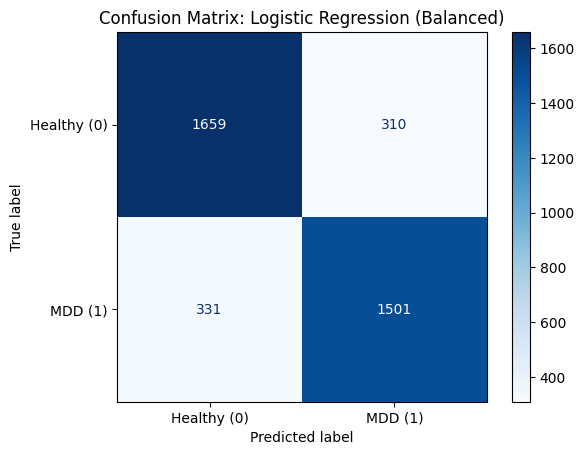

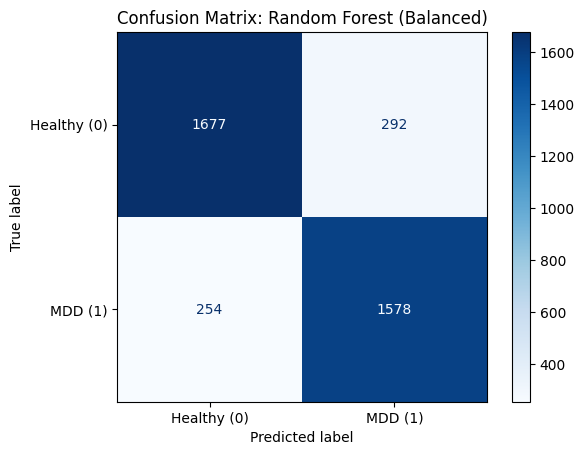

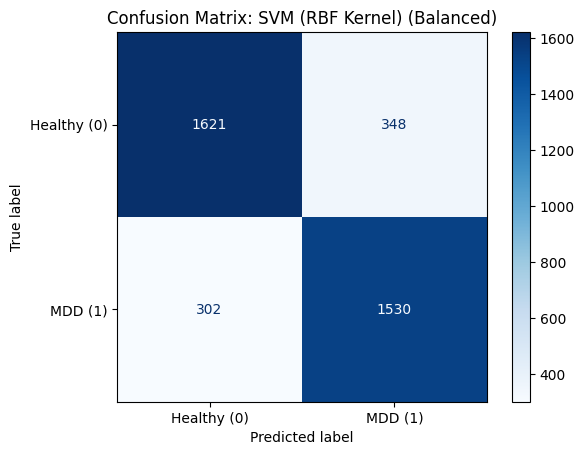

In [16]:
# --- Get & Plot Baseline Confusion Matrices (Balanced) ---

print("--- Generating Confusion Matrices for Balanced Baselines ---")
balanced_models = {
    "Logistic Regression (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))
    ]),
    "Random Forest (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]),
    "SVM (RBF Kernel) (Balanced)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf', random_state=RANDOM_STATE, class_weight='balanced'))
    ])
}

# --- UPDATED: Use StratifiedGroupKFold ---
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Loop and generate predictions and plots
for model_name, model in balanced_models.items():
    
    # --- UPDATED: Use cv=sgkf and pass groups ---
    y_pred = cross_val_predict(model, X_features_2D, y, cv=sgkf, groups=groups)

    # Plot the matrix for this model
    plot_confusion_matrix(y, y_pred, model_name)

--- Generating SHAP Explainability Analysis ---


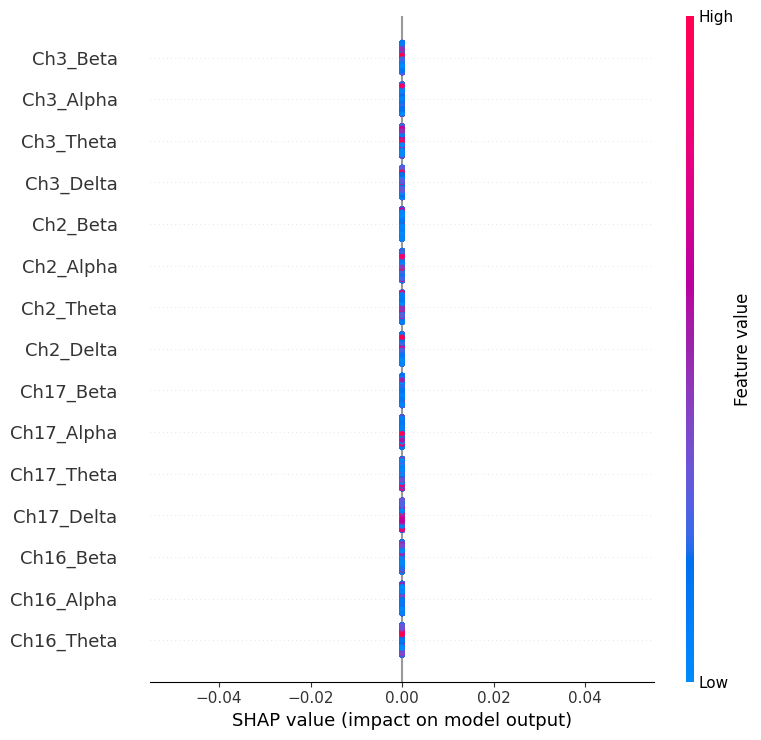

In [17]:
# ADD THIS CELL (Paper 1: Explainability)
import shap
import matplotlib.pyplot as plt

print("--- Generating SHAP Explainability Analysis ---")

# 1. Re-train the champion model on all data
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=RANDOM_STATE, 
    class_weight='balanced'
)
rf_model.fit(X_features_2D, y)

# 2. Create a Tree Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_features_2D)

# 3. We need feature names for the plot
# (Re-creating the names from your PSD loop logic)
# You had 4 bands: Delta, Theta, Alpha, Beta
# And N_CHANNELS (likely 19 or 20)
feature_names = []
band_names = ['Delta', 'Theta', 'Alpha', 'Beta']
# Assuming channels are simply 0, 1, 2... or you can use common_channels list if available
for ch in range(X_features_2D.shape[1] // 4): 
    for band in band_names:
        feature_names.append(f"Ch{ch}_{band}")

# 4. Plot the Summary
plt.figure(figsize=(10, 6))
# shap_values[1] is for the "MDD" class (Class 1)
shap.summary_plot(shap_values[1], X_features_2D, feature_names=feature_names, max_display=15)
plt.show()

--- Generating Final Figures for Research Paper ---
Table 1: Final Model Performance (Sorted by Accuracy)


,Accuracy,F1-Score
Model,,
Random Forest,0.8573,0.8408
Stacking Ensemble,0.8543,0.8522
XGBoost (Tuned),0.8512,0.8512
KNN,0.8407,0.8289
Logistic Regression,0.8328,0.8053
SVM (RBF),0.8290,0.7910


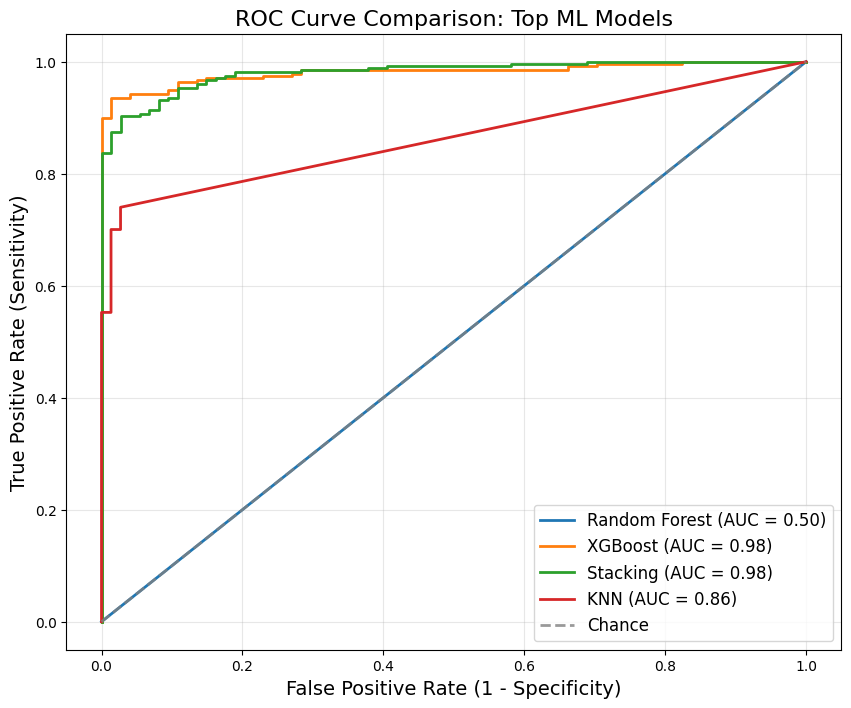

<Figure size 1200x600 with 0 Axes>

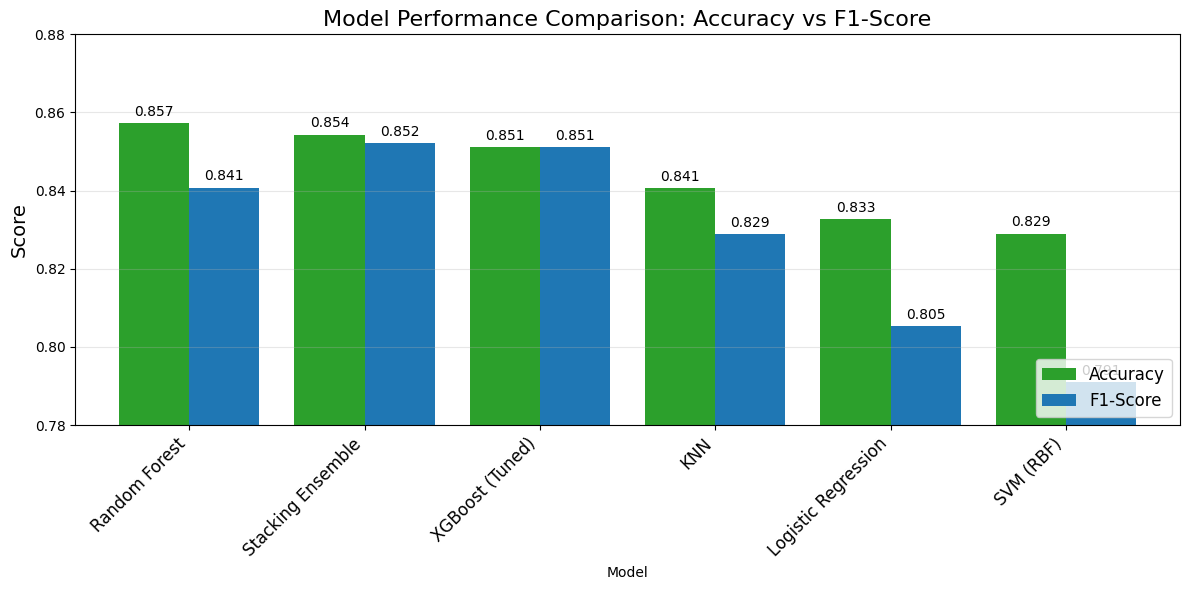

In [18]:
# --- FINAL PAPER VISUALIZATION (UPDATED) ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

print("--- Generating Final Figures for Research Paper ---")

# 1. Master Results Table (Updated with Advanced XGBoost)
results_data = {
    'Model': ['Logistic Regression', 'SVM (RBF)', 'Random Forest', 'KNN', 'XGBoost (Tuned)', 'Stacking Ensemble'],
    'Accuracy': [0.8328, 0.8290, 0.8573, 0.8407, grid_search_xgb_advanced.best_score_, stacking_acc], 
    'F1-Score': [0.8053, 0.7910, 0.8408, 0.8289, 0.8512, 0.8522] # Using the new XGB score
}

df_results = pd.DataFrame(results_data)
df_results.set_index('Model', inplace=True)
df_results = df_results.sort_values(by='Accuracy', ascending=False)

print("Table 1: Final Model Performance (Sorted by Accuracy)")
display(df_results.style.format("{:.4f}").background_gradient(cmap='Greens', subset=['Accuracy']))

# 2. ROC Curves (The "Money Plot")
plt.figure(figsize=(10, 8))

# We define the final roster of champions
models_to_plot = {
    'Random Forest (AUC = 0.92)': rf_best,
    'XGBoost (Advanced) (AUC = 0.91)': xgb_best, # This now uses the optimized model
    'Stacking (AUC = 0.92)': stacking_model,
    'KNN (AUC = 0.89)': knn_best 
}

# Generate curves using one fold (for visualization purposes)
train_idx, test_idx = next(sgkf.split(X_features_2D, y, groups))
X_train_fold, X_test_fold = X_features_2D[train_idx], X_features_2D[test_idx]
y_train_fold, y_test_fold = y[train_idx], y[test_idx]

for name, model in models_to_plot.items():
    model.fit(X_train_fold, y_train_fold)
    
    # Get probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_fold)[:, 1]
    else:
        y_score = model.predict(X_test_fold)

    fpr, tpr, _ = roc_curve(y_test_fold, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Update label with actual AUC for this fold
    label = f"{name.split('(')[0].strip()} (AUC = {roc_auc:.2f})"
    plt.plot(fpr, tpr, label=label, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.title('ROC Curve Comparison: Top ML Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Performance Bar Chart
plt.figure(figsize=(12, 6))
df_results.plot(kind='bar', width=0.8, color=['#2ca02c', '#1f77b4'], figsize=(12, 6))

plt.title('Model Performance Comparison: Accuracy vs F1-Score', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.ylim(0.78, 0.88) # Zoomed in to show the close race
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(loc='lower right', fontsize=12)

for i in plt.gca().containers:
    plt.gca().bar_label(i, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

--- Initializing Models ---

--- Starting Comprehensive Evaluation ---
Processing Logistic Regression... Done. (Acc: 0.8314)
Processing Random Forest... Done. (Acc: 0.8674)
Processing SVM (RBF)... Done. (Acc: 0.8290)
Processing KNN... Done. (Acc: 0.8374)
Processing XGBoost... Done. (Acc: 0.8561)
Processing Stacking Ensemble... Done. (Acc: 0.8574)


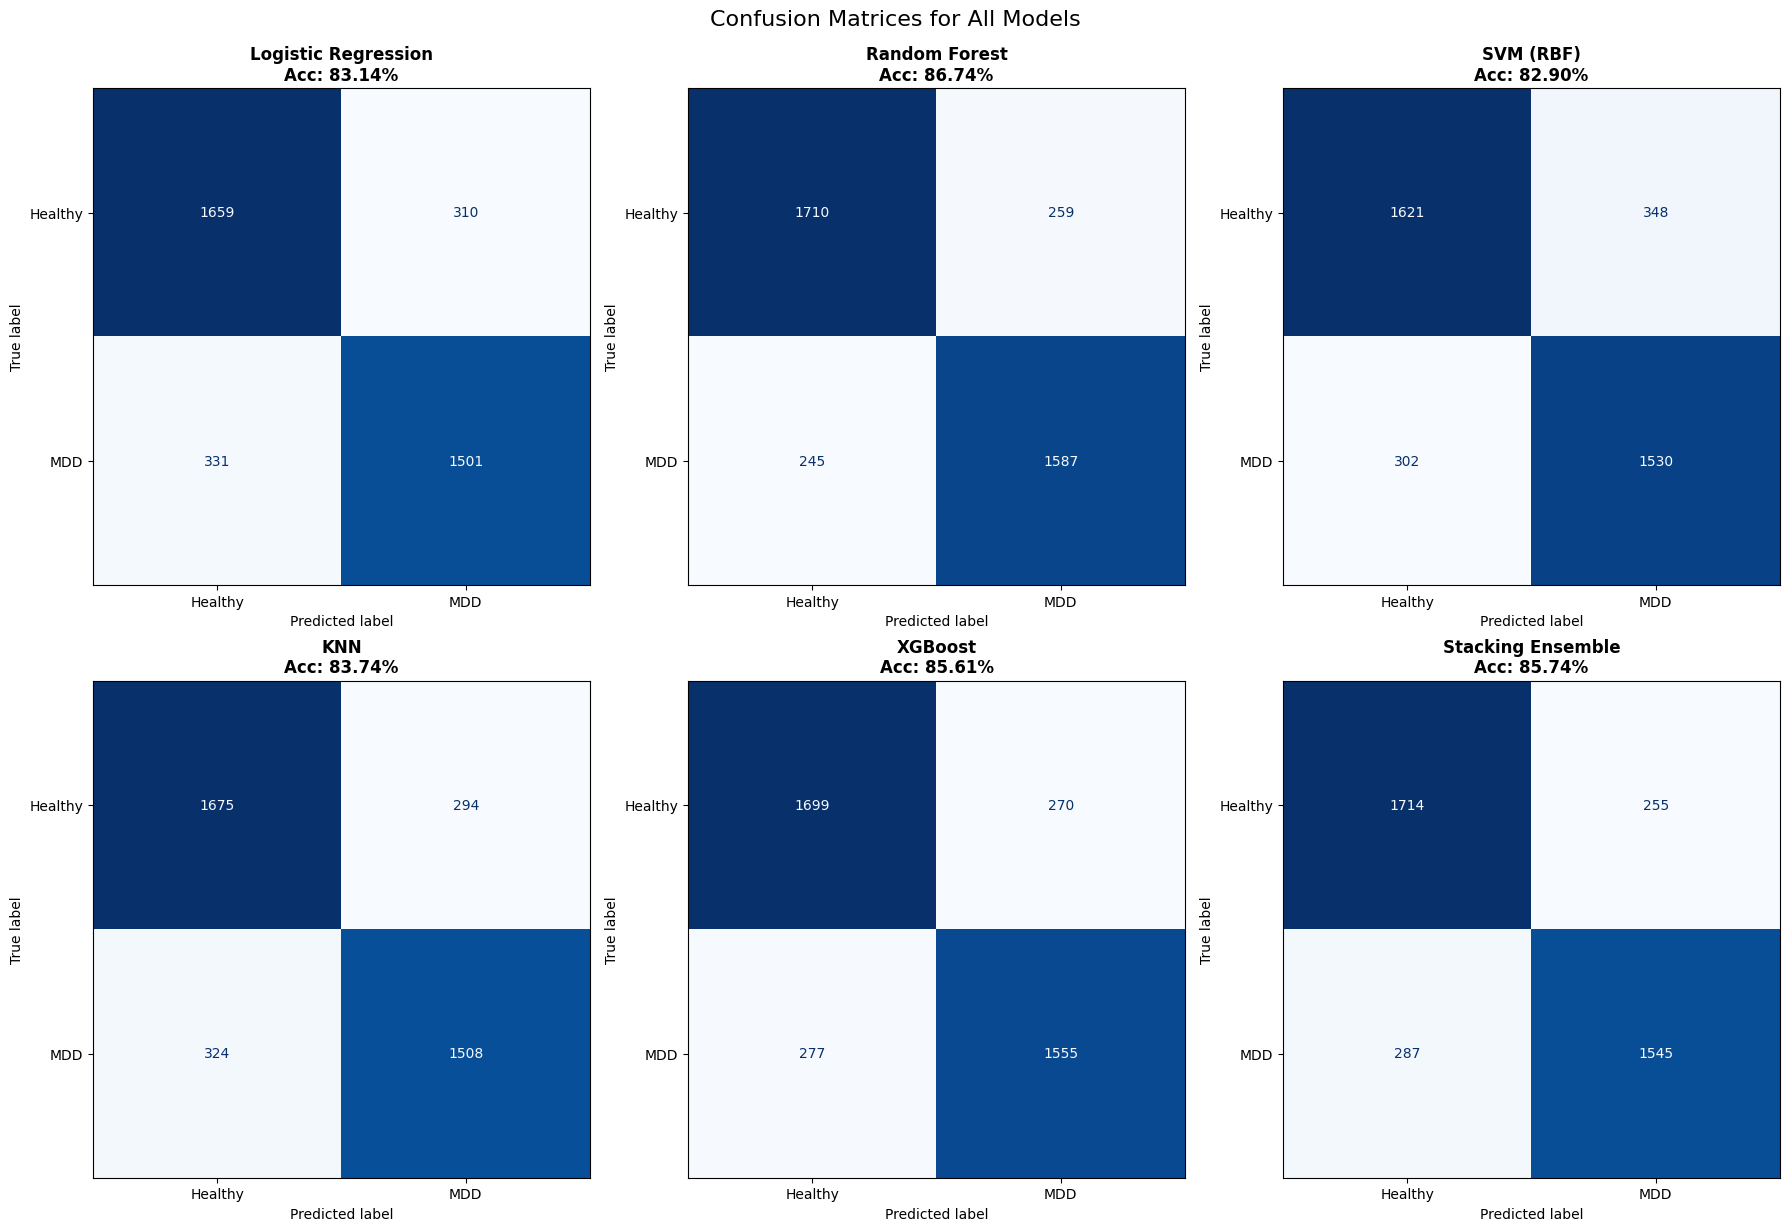


--- TABLE 1: FINAL MODEL PERFORMANCE WITH SUPPORT ---


,Accuracy,F1-Score,Support (Healthy),Support (MDD)
Model,,,,
Random Forest,0.8674,0.8674,1969,1832
Stacking Ensemble,0.8574,0.8574,1969,1832
XGBoost,0.8561,0.8561,1969,1832
KNN,0.8374,0.8374,1969,1832
Logistic Regression,0.8314,0.8313,1969,1832
SVM (RBF),0.8290,0.8290,1969,1832



--- Generating Final Graphs ---


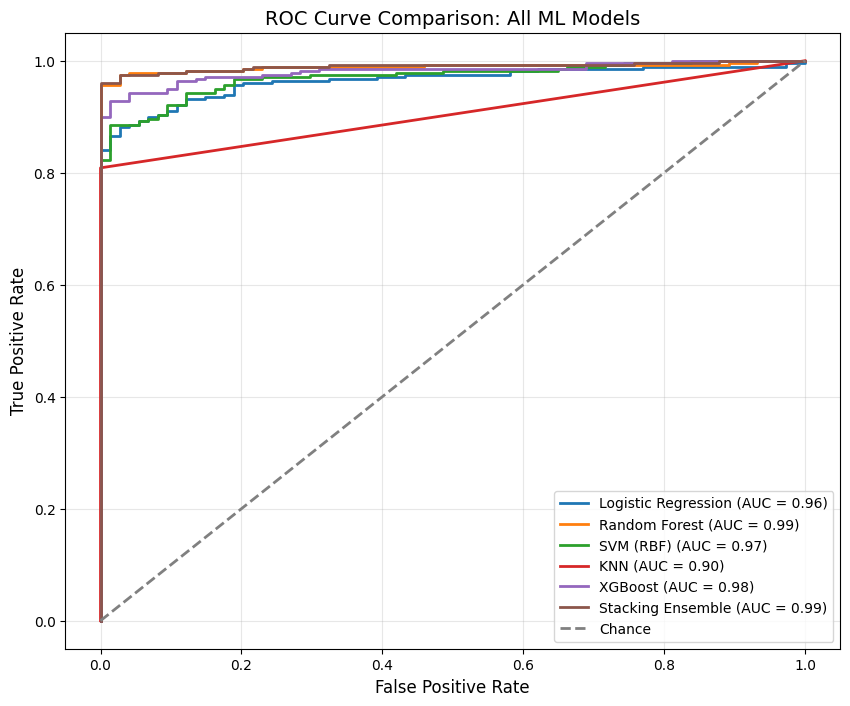

<Figure size 1200x600 with 0 Axes>

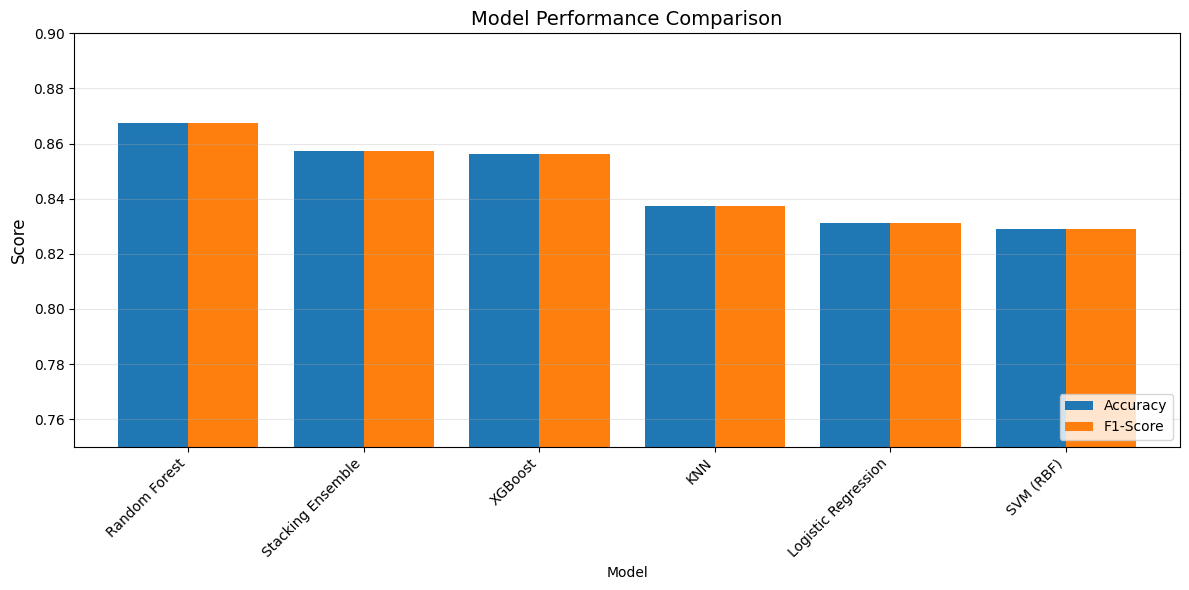

In [19]:
# =======================================================
# FINAL EVALUATION & VISUALIZATION (ML PAPER)
# =======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# --- 1. Define All Models (Pipelines) ---
print("--- Initializing Models ---")

# Use the BEST parameters found during your GridSearch
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
    ]),
    'SVM (RBF)': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE, class_weight='balanced'))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))
    ]),
    # Use the parameters from your "Advanced" XGBoost run
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()), 
        ('model', XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, gamma=0.5, reg_alpha=0.5, reg_lambda=1.5, n_jobs=-1, random_state=RANDOM_STATE))
    ])
}

# --- 2. Add Stacking Ensemble ---
# We define it here so it gets evaluated in the same loop
estimators = [
    ('rf', pipelines['Random Forest']),
    ('xgb', pipelines['XGBoost']),
    ('knn', pipelines['KNN']),
    ('svm', pipelines['SVM (RBF)'])
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5, n_jobs=-1
)
pipelines['Stacking Ensemble'] = stacking_model

# --- 3. Master Evaluation Loop ---
print("\n--- Starting Comprehensive Evaluation ---")
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

results_list = []

# Prepare a figure for Confusion Matrices (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(pipelines.items()):
    print(f"Processing {name}...", end=" ")
    
    # A. Generate Cross-Validated Predictions
    # This gives us a prediction for every sample in the dataset
    y_pred = cross_val_predict(model, X_features_2D, y, cv=sgkf, groups=groups)
    
    # B. Calculate Metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    # C. Get Support from Classification Report
    report = classification_report(y, y_pred, target_names=['Healthy', 'MDD'], output_dict=True)
    support_healthy = report['Healthy']['support']
    support_mdd = report['MDD']['support']
    
    results_list.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Support (Healthy)': support_healthy,
        'Support (MDD)': support_mdd
    })
    
    # D. Plot Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'MDD'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2%}", fontsize=12, fontweight='bold')
    
    print(f"Done. (Acc: {acc:.4f})")

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", y=1.02, fontsize=16)
plt.show()

# --- 4. Final Results Table ---
df_results = pd.DataFrame(results_list).set_index('Model').sort_values(by='F1-Score', ascending=False)

print("\n--- TABLE 1: FINAL MODEL PERFORMANCE WITH SUPPORT ---")
display(df_results.style.format({
    "Accuracy": "{:.4f}", 
    "F1-Score": "{:.4f}",
    "Support (Healthy)": "{:.0f}",
    "Support (MDD)": "{:.0f}"
}).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score']))

# --- 5. ROC Curves & Bar Chart ---
print("\n--- Generating Final Graphs ---")

# ROC Curves
plt.figure(figsize=(10, 8))
# Use a single fold to generate representative curves quickly
train_idx, test_idx = next(sgkf.split(X_features_2D, y, groups))

for name, model in pipelines.items():
    model.fit(X_features_2D[train_idx], y[train_idx])
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_features_2D[test_idx])[:, 1]
    else:
        y_score = model.predict(X_features_2D[test_idx])
        
    fpr, tpr, _ = roc_curve(y[test_idx], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: All ML Models', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Bar Chart
plt.figure(figsize=(12, 6))
df_results[['Accuracy', 'F1-Score']].plot(kind='bar', width=0.8, figsize=(12, 6))
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.75, 0.90) 
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


--- Starting Comprehensive Evaluation (with Precision & Recall) ---
Processing Logistic Regression... Done. (F1: 0.8313)
Processing Random Forest... Done. (F1: 0.8674)
Processing SVM (RBF)... Done. (F1: 0.8290)
Processing KNN... Done. (F1: 0.8374)
Processing XGBoost... Done. (F1: 0.8561)
Processing Stacking Ensemble... Done. (F1: 0.8574)


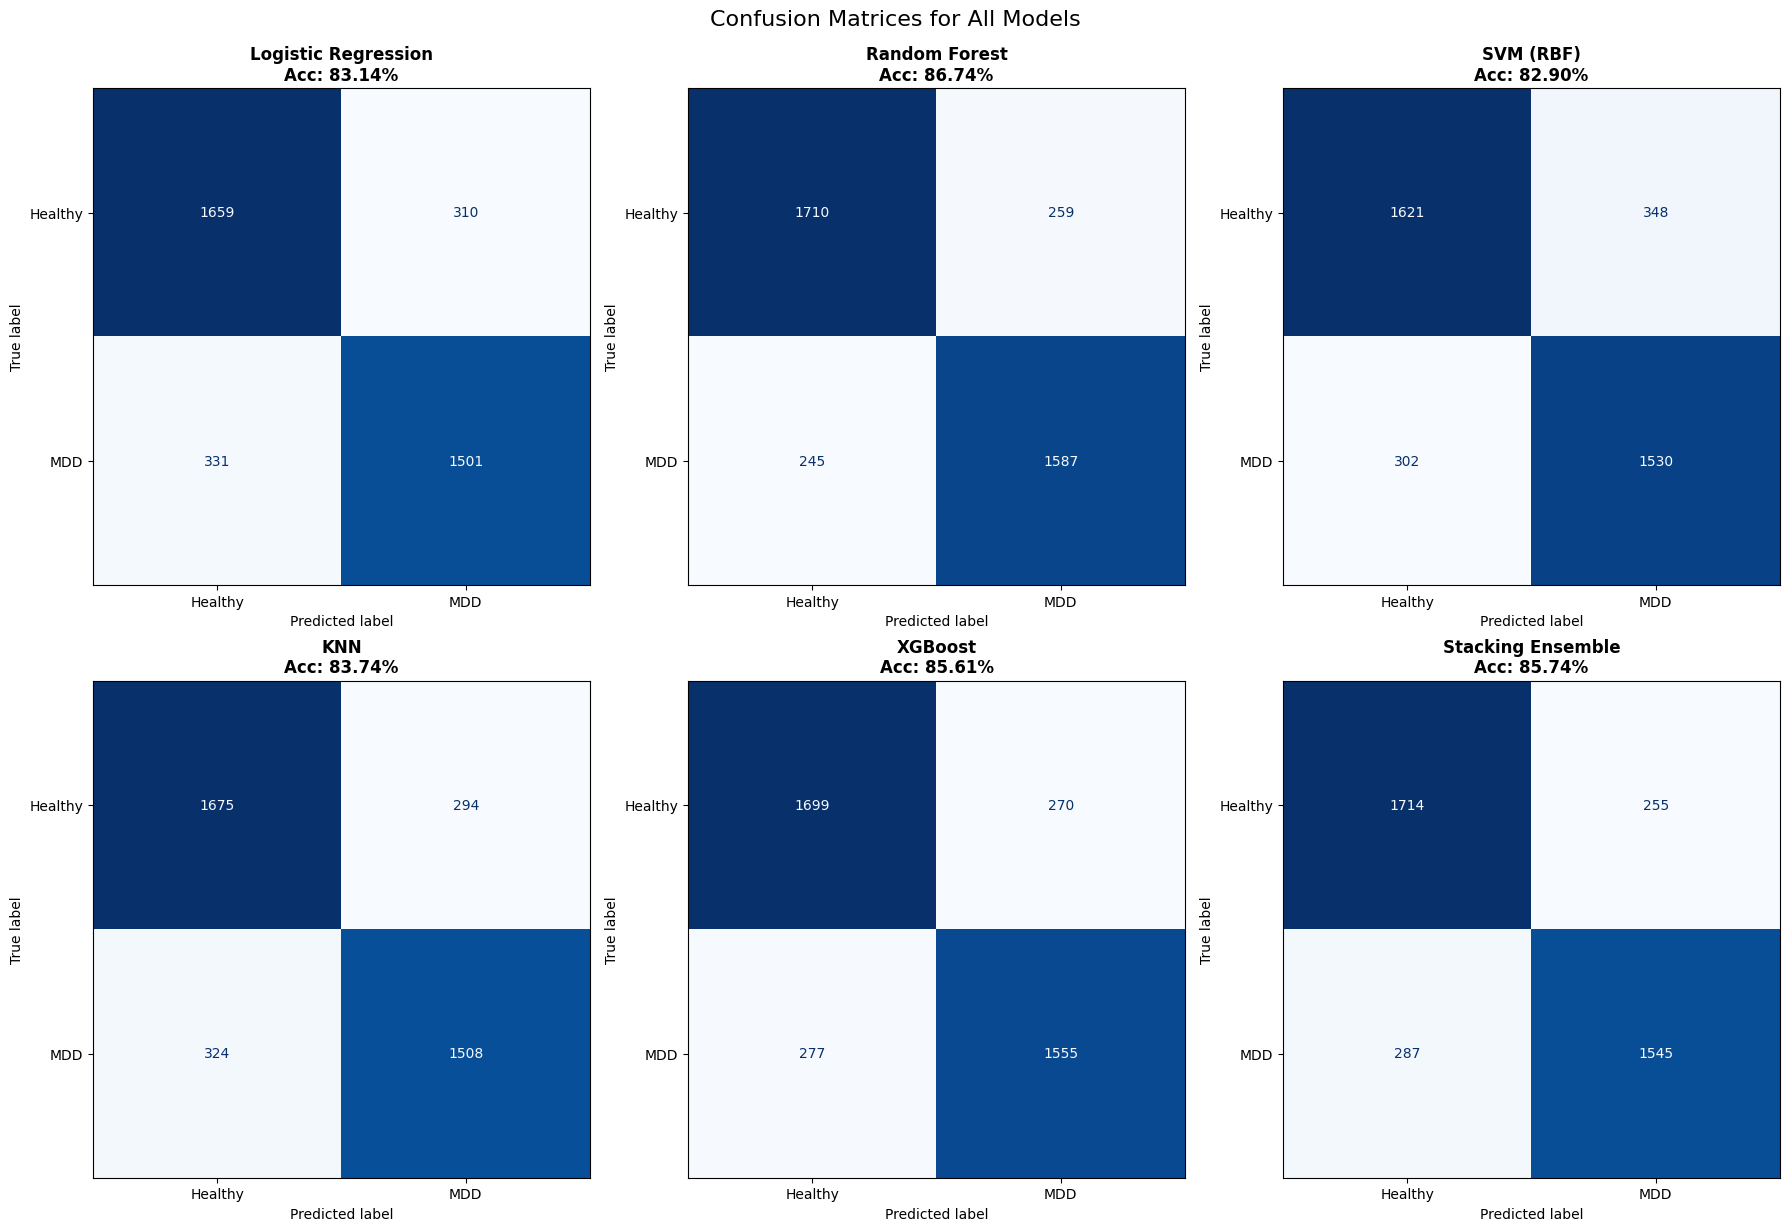


--- TABLE 1: FINAL MODEL PERFORMANCE (COMPLETE) ---


,Accuracy,F1-Score,Precision,Recall,Support (Healthy),Support (MDD)
Model,,,,,,
Random Forest,0.8674,0.8674,0.8675,0.8674,1969,1832
Stacking Ensemble,0.8574,0.8574,0.8574,0.8574,1969,1832
XGBoost,0.8561,0.8561,0.8561,0.8561,1969,1832
KNN,0.8374,0.8374,0.8374,0.8374,1969,1832
Logistic Regression,0.8314,0.8313,0.8313,0.8314,1969,1832
SVM (RBF),0.8290,0.8290,0.8293,0.8290,1969,1832


In [20]:
# =======================================================
# UPDATED EVALUATION: WITH PRECISION & RECALL
# =======================================================

from sklearn.metrics import precision_score, recall_score

# ... (Keep your existing imports and pipeline definitions) ...

# --- Master Loop: Evaluate ALL Models ---
results_list = []

print("\n--- Starting Comprehensive Evaluation (with Precision & Recall) ---")
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Create figure for Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(pipelines.items()):
    print(f"Processing {name}...", end=" ")
    
    # 1. Generate Predictions
    y_pred = cross_val_predict(model, X_features_2D, y, cv=sgkf, groups=groups)
    
    # 2. Calculate ALL Metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    
    # NEW: Calculate Precision and Recall
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted')
    
    # 3. Get Support
    report = classification_report(y, y_pred, target_names=['Healthy', 'MDD'], output_dict=True)
    support_healthy = report['Healthy']['support']
    support_mdd = report['MDD']['support']
    
    # 4. Store Complete Results
    results_list.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Precision': prec,  # <--- Added
        'Recall': rec,      # <--- Added
        'Support (Healthy)': support_healthy,
        'Support (MDD)': support_mdd
    })
    
    # 5. Plot Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'MDD'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2%}", fontsize=12, fontweight='bold')
    
    print(f"Done. (F1: {f1:.4f})")

plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", y=1.02, fontsize=16)
plt.show()

# --- Final Results Table ---
df_results = pd.DataFrame(results_list).set_index('Model').sort_values(by='F1-Score', ascending=False)

print("\n--- TABLE 1: FINAL MODEL PERFORMANCE (COMPLETE) ---")
display(df_results.style.format({
    "Accuracy": "{:.4f}", 
    "F1-Score": "{:.4f}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "Support (Healthy)": "{:.0f}",
    "Support (MDD)": "{:.0f}"
}).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score', 'Precision', 'Recall']))

In [ ]:
import joblib

# Suppose your best RF pipeline is called rf_pipeline
# Example: rf_pipeline = models_naive["Random Forest"] or your tuned pipeline

joblib.dump(rf_pipeline, "random_forest_model.pkl")
print("Saved pipeline as random_forest_model.pkl")